# PCA using Sentinel-2

Authors:

* Jeroen Wannijn

# Introduction
In this notebook, we will perform dimensionality reduction analysis on a full data cube of preprocessed Sentinel data for the WEED project. The data has been retrieved from and processed on openEO. The models we use are pretrained and generated with Scikit-learn. This notebook focuses primarily on the implementation of the model and the subsequent analysis. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import rasterio
import xarray as xr
import openeo
from openeo.processes import quantiles

# openeo version
openeo.client_version()

'0.40.0'

Creates a output directory if it doesn't exist.

In [2]:
base_path = Path("results")
if not base_path.is_dir():
    base_path.mkdir()

## Authentication

We first need to connect to an openEO provider. Most providers require you to register an account, and provide you with a basic amount of processing credits. 
In this notebook we will use the Copernicus Data Scpace Ecosystem as openEO provider.

All the known openEO providers and their services:
https://hub.openeo.org/ 

More info on authentication:
https://open-eo.github.io/openeo-python-client/auth.html

Run the `authenticate_oidc()` method again in case you can no longer connect. The token expires after a certain time.

In [3]:
backend_url = "openeo.dataspace.copernicus.eu/"

eoconn = openeo.connect(backend_url)
eoconn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

Create job options for running jobs on CSDE, the models are trained for 3 componenets

In [12]:
models_url = "https://s3.waw3-1.cloudferro.com/swift/v1/ecdc-waw3-1-ekqouvq3otv8hmw0njzuvo0g4dy0ys8r985n7dggjis3erkpn5o/tests/JeroenW/PCA/dim_reduction_models.zip"
dependencies_url = (
    "https://s3.waw3-1.cloudferro.com/swift/v1/project_dependencies/dim_reduction_deps.zip"
    )
job_options = {
    "driver-memory": "4G",
    "driver-memoryOverhead": "4G",
    "driver-cores": 1,
    "executor-memory": "2000m",
    "executor-memoryOverhead": "256m",
    "python-memory": "4G",
    "executor-cores": 1,
    "max-executors": 20,
    "logging-threshold": "info",
    'udf-dependency-archives': [
        f"{dependencies_url}#udf-py-deps",
        f"{models_url}#sklearn-models"],
 }

## Load collection

We start off by loading in a collection. In this case, we are loading in Sentinel-2 L2A. More information on the collections available can be displayed with `eoconn.list_collections()`.
Use `eoconn.describe_collection("SENTINEL2_L2A")` for example to get the description of a specific collection.

More information on finding and loading data: 
https://open-eo.github.io/openeo-python-client/data_access.html

In [5]:
BBOX = {"east": 4878500, "south": 2897000, "west": 4877000, "north": 2898500, 'crs': 'EPSG:3035'} # 1.5x1.5km bbox in Germany
DATE_START = "2021-01-01"
DATE_END = "2022-01-01"

*Select usable observations*:

For this exercise we use the derivatives of the 13 Sentinel-2 bands + NDVI by applying a spatial reduction
- mean 
- median
- max
- min
- q5
- q25
- q75
- q95

This leads to 112 (14x8) dimension to reduce in a dimensionality reduction model.

Load collection + calculate NDVI

In [6]:
data_cube = eoconn.load_collection(
    "SENTINEL2_L2A",  # or your collection id
    spatial_extent=BBOX,
    temporal_extent=[DATE_START, DATE_END],
    bands=['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12'],
    max_cloud_cover=10
)

Mask cloud data

In [7]:
scl = eoconn.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=[DATE_START, DATE_END],
    spatial_extent=BBOX,
    bands=["SCL"],
    max_cloud_cover=10,
)

cloud_mask = scl.process(
    "to_scl_dilation_mask",
    data=scl,
    kernel1_size=17, kernel2_size=77,
    mask1_values=[2, 4, 5, 6, 7],
    mask2_values=[3, 8, 9, 10, 11],
    erosion_kernel_size=3)

data_cube_masked = data_cube.mask(cloud_mask)

Calculate NDVI

In [8]:
data_cube_masked = data_cube_masked.ndvi(red="B04", nir="B08", target_band='NDVI')

Temporally reduce data cube each time with different statistic

In [9]:
# Get original band labels
band_labels = data_cube_masked.metadata.band_names

# Temporal reducersa nd prefix new band names
mean_cube = data_cube_masked.mean_time().rename_labels("bands", [f"{b}_mean" for b in band_labels])
median_cube = data_cube_masked.reduce_dimension("t", reducer="median").rename_labels("bands", [f"{b}_median" for b in band_labels])
min_cube = data_cube_masked.min_time().rename_labels("bands", [f"{b}_min" for b in band_labels])
max_cube = data_cube_masked.max_time().rename_labels("bands", [f"{b}_max" for b in band_labels])

q25_cube = data_cube_masked.reduce_dimension(
    dimension="t",
    reducer=lambda data: quantiles(data, probabilities=[0.25]),
).rename_labels("bands", [f"{b}_q25" for b in band_labels])

q75_cube = data_cube_masked.reduce_dimension(
    dimension="t",
    reducer=lambda data: quantiles(data, probabilities=[0.75]),
).rename_labels("bands", [f"{b}_q75" for b in band_labels])


q05_cube = data_cube_masked.reduce_dimension(
    dimension="t",
    reducer=lambda data: quantiles(data, probabilities=[0.05]),
).rename_labels("bands", [f"{b}_q05" for b in band_labels])

q95_cube = data_cube_masked.reduce_dimension(
    dimension="t",
    reducer=lambda data: quantiles(data, probabilities=[0.95]),
).rename_labels("bands", [f"{b}_q95" for b in band_labels])



In [10]:
sentinel_master_cube = mean_cube\
    .merge_cubes(median_cube)\
    .merge_cubes(min_cube)\
    .merge_cubes(max_cube)\
    .merge_cubes(q25_cube)\
    .merge_cubes(q75_cube)\
    .merge_cubes(q05_cube)\
    .merge_cubes(q95_cube)

Download to view offline

In [17]:
job = sentinel_master_cube.create_job(
    title="building_S2_stat_cube", out_format="NetCDF", job_options=job_options)
job.start_and_wait()
job.download_result(base_path / "S2_master_cube.nc")

0:00:00 Job 'j-250625123501453e97c019914bc9e2c0': send 'start'
0:00:13 Job 'j-250625123501453e97c019914bc9e2c0': created (progress 0%)
0:00:18 Job 'j-250625123501453e97c019914bc9e2c0': created (progress 0%)
0:00:24 Job 'j-250625123501453e97c019914bc9e2c0': created (progress 0%)
0:00:32 Job 'j-250625123501453e97c019914bc9e2c0': running (progress N/A)
0:00:42 Job 'j-250625123501453e97c019914bc9e2c0': running (progress N/A)
0:00:55 Job 'j-250625123501453e97c019914bc9e2c0': running (progress N/A)
0:01:10 Job 'j-250625123501453e97c019914bc9e2c0': running (progress N/A)
0:01:30 Job 'j-250625123501453e97c019914bc9e2c0': running (progress N/A)
0:01:54 Job 'j-250625123501453e97c019914bc9e2c0': running (progress N/A)
0:02:24 Job 'j-250625123501453e97c019914bc9e2c0': running (progress N/A)
0:03:01 Job 'j-250625123501453e97c019914bc9e2c0': running (progress N/A)
0:03:48 Job 'j-250625123501453e97c019914bc9e2c0': running (progress N/A)
0:04:46 Job 'j-250625123501453e97c019914bc9e2c0': running (progr

WindowsPath('results/S2_master_cube.nc')

## Visualise RGB to get a view of the area
Load RGB data from Sentinel-2 collection

In [12]:
rgb_cube = eoconn.load_collection(
    "SENTINEL2_L2A",  # or your collection id
    spatial_extent=BBOX,
    temporal_extent=[DATE_START, DATE_END],
    bands=['B02', 'B03', 'B04'],
    max_cloud_cover=10
)

rgb_cube = rgb_cube.mask(cloud_mask)

# Reduce to a single time slice, e.g. take median over time to get 2D image
rgb_cube = rgb_cube.reduce_dimension(dimension='t', reducer='mean')

Download Sentinel-2 RGB data

In [ ]:
# rgb_cube.download(base_path / "rgb_image_cube.tiff")

Visualize RGB data

Pixel Size: 10.0 x 10.0 units


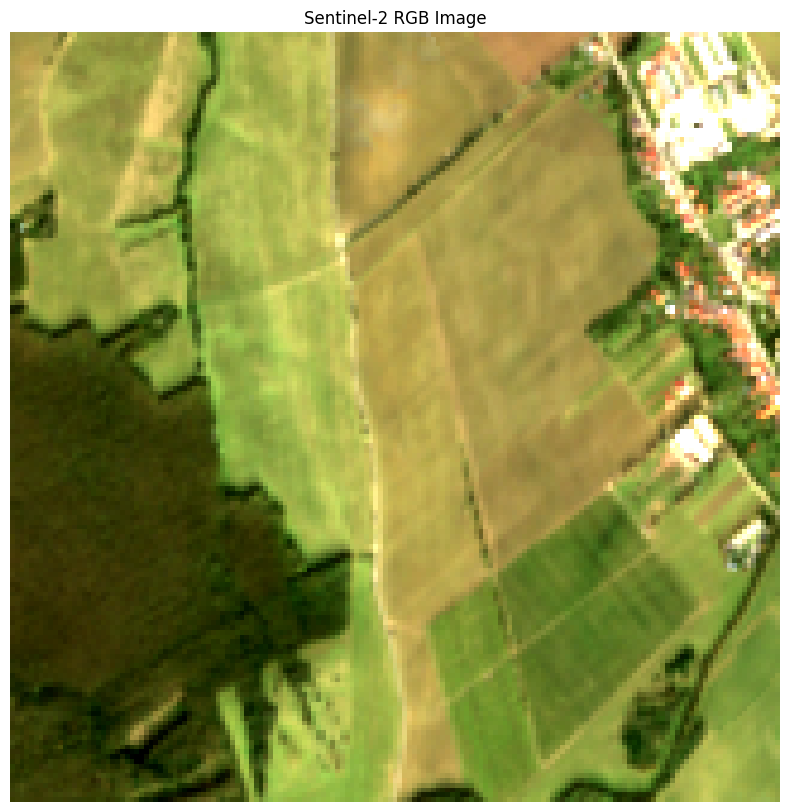

In [10]:
with rasterio.open(base_path / "rgb_image_cube.tiff") as src:
    pixel_size_x = src.transform.a
    pixel_size_y = -src.transform.e
    print(f"Pixel Size: {pixel_size_x} x {pixel_size_y} units")

    r = src.read(3)  # Band 4
    g = src.read(2)  # Band 3
    b = src.read(1)  # Band 2

rgb = np.stack([r, g, b], axis=0)
rgb_img = np.transpose(rgb, (1, 2, 0))

# Normalize using percentiles
def normalize_percentile(img, lower=2, upper=98):
    p_low, p_high = np.percentile(img, (lower, upper))
    img_clipped = np.clip(img, p_low, p_high)
    return (img_clipped - p_low) / (p_high - p_low)

rgb_norm = normalize_percentile(rgb_img)

plt.figure(figsize=(10, 10))
plt.imshow(rgb_norm)
plt.title("Sentinel-2 RGB Image")
plt.axis("off")
plt.show()

## Calculate PCA & T-SNE


### Select signifcant bands

In [ ]:
# TODO First select significant bands

### Dimensionality Reduction

Apply the Dimensionality Reduction UDF with PCA within a neighbourhood of 512x512 pixels, you can improve results by increasing the pixel input by enlarging the neighbourhoud size.

In [ ]:
pca_udf_obj = openeo.UDF.from_file("udf_dim_reduction.py",
                                   context={"model_type": "PCA"})
components = sentinel_master_cube.apply_neighborhood(
    process=pca_udf_obj,
    size=[
        {"dimension": "x", "value": 384, "unit": "px"},
        {"dimension": "y", "value": 384, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 64, "unit": "px"},
        {"dimension": "y", "value": 64, "unit": "px"},
    ],
)
pca_job = components.create_job(
    title="pca_job", out_format="NetCDF", job_options=job_options
)
pca_job.start_and_wait()
pca_job.download_result("results/results_pca.nc")

0:00:00 Job 'j-2506260738114442a72f799a884a4431': send 'start'
0:00:12 Job 'j-2506260738114442a72f799a884a4431': created (progress 0%)
0:00:17 Job 'j-2506260738114442a72f799a884a4431': created (progress 0%)
0:00:24 Job 'j-2506260738114442a72f799a884a4431': created (progress 0%)
0:00:31 Job 'j-2506260738114442a72f799a884a4431': created (progress 0%)
0:00:41 Job 'j-2506260738114442a72f799a884a4431': created (progress 0%)
0:00:56 Job 'j-2506260738114442a72f799a884a4431': created (progress 0%)
0:01:11 Job 'j-2506260738114442a72f799a884a4431': running (progress N/A)
0:01:31 Job 'j-2506260738114442a72f799a884a4431': running (progress N/A)
0:01:55 Job 'j-2506260738114442a72f799a884a4431': running (progress N/A)
0:02:24 Job 'j-2506260738114442a72f799a884a4431': running (progress N/A)
0:03:02 Job 'j-2506260738114442a72f799a884a4431': running (progress N/A)
0:03:49 Job 'j-2506260738114442a72f799a884a4431': running (progress N/A)
0:04:53 Job 'j-2506260738114442a72f799a884a4431': finished (progres

WindowsPath('results/results_pca.nc')

Apply the Dimensionality Reduction UDF with t-SNE. 

T-SNE requires more memory and apply is recomended for quick test results compared to apply_nieghbourhood.

In [ ]:
tsne_udf_obj = openeo.UDF.from_file("udf_dim_reduction.py",
                                   context={"model_type": "TSNE"})
components = sentinel_master_cube.apply(
    process=tsne_udf_obj,
)
tsne_job = components.create_job(
    title="tsne_job", out_format="NetCDF", job_options=job_options
)
tsne_job.start_and_wait()
tsne_job.download_result("results/results_tsne.nc")

## Visualise Output
Load dataset


In [ ]:
pca_job_data = xr.open_dataset(base_path / "results_pca.nc")
#tsne_job_data = xr.open_dataset(base_path / "components_tsne_local.nc")

In [19]:
def concat_features_to_bands_dim(ds: xr.DataArray):
    # List band variables
    band_vars = [var for var in ds.data_vars if ds[var].dtype.kind in 'fc' and set(ds[var].dims) == {'y', 'x'}]

    cube = xr.concat([ds[var] for var in band_vars], dim="bands")
    cube = cube.assign_coords(bands=band_vars)  # name the bands
    return cube.rename('__xarray_dataarray_variable__')

def plot_components(data_array: str, model_name: str, run_loc: str):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    for i, ax in enumerate(axes):
        comp_data = data_array.isel(bands=i)
        # Use percentiles to plot as vmin & vmax to highlight differences
        vmin = comp_data.quantile(0.45).item()
        vmax = comp_data.quantile(0.55).item()
        
        im = ax.imshow(comp_data, vmin=vmin, vmax=vmax)
        ax.set_title(f'COMP{i+1}')
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Add a general title
    fig.suptitle(f"{model_name} Components - {run_loc} Dataset", fontsize=16)

    plt.tight_layout()
    plt.show()

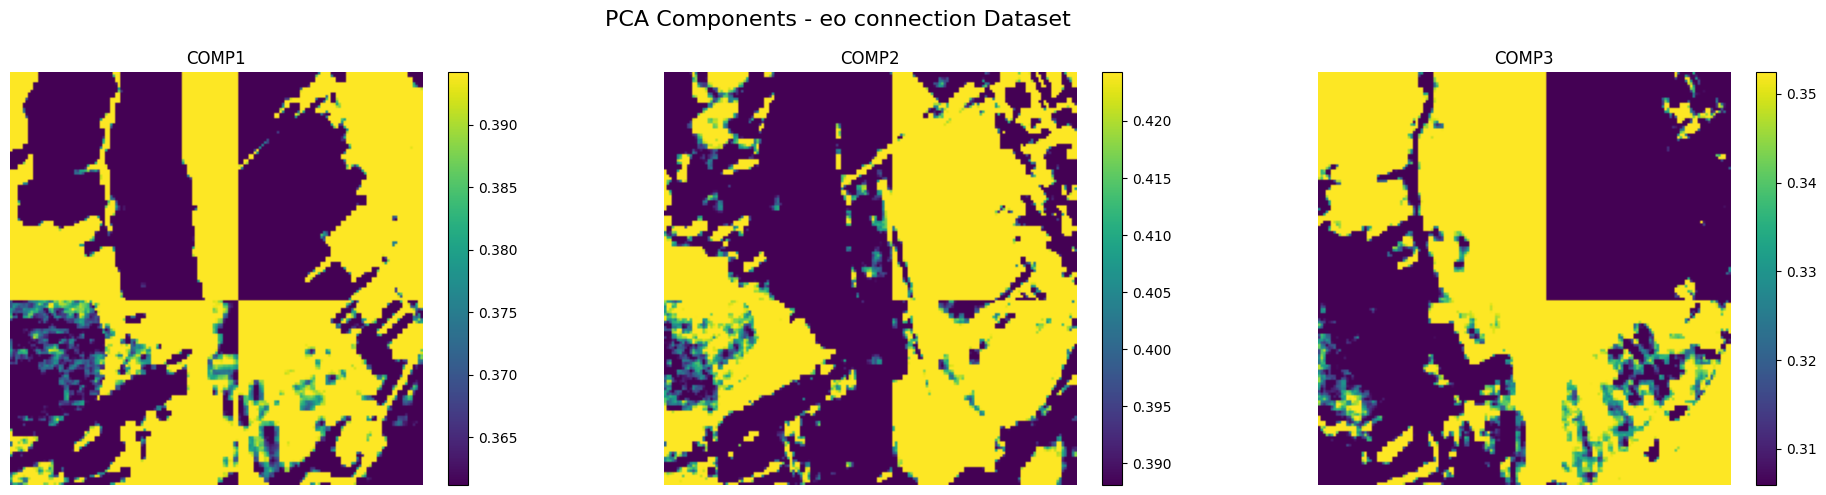

In [21]:
pca_job_data_array= concat_features_to_bands_dim(pca_job_data)
# tsne_job_data_array= concat_features_to_bands_dim(tsne_job_data)

plot_components(pca_job_data_array, "PCA", "eo connection")
# plot_components(tsne_job_data_array, "T-SNE", "eo connection")